## Post 방식 크롤링

목표 : 한국금거래소의 일별 금 가격 전체 데이터를 수집(2008 ~ 현재)하여 시각화하고,  
시기별 특정 이벤트를 annotiopn하여 가격 변동과의 관계를 살펴본다 

[한국금거래소](https://www.koreagoldx.co.kr/main/html.php?agencyCode=&htmid=goods/gold_list.html)

![gold_fluctuation](image/fluctuation.png)

In [879]:
import urllib.request as req
import pandas as pd
import requests
from selenium import webdriver
import time
from datetime import datetime
import matplotlib.pyplot as plt

### 1-1. 웹 페이지 소스 데이터 가져오기 : requests

한국금거래소는 post 방식으로 클라이언트의 요청에 response 하므로 먼저 requests모듈을  
이용하여 head 정보 및 data params를 함께 전달하여 페이지 소스 획득이 가능한지 살펴본다



[requests docs](https://docs.python-requests.org/en/master/user/quickstart/)

In [832]:
# 금 시세 테이블이 있는 url
url_target = 'https://www.koreagoldx.co.kr/main/html.php?agencyCode=&htmid=goods/gold_list.html'

[header 및 payload]

In [833]:
header = {'User-Agent':'Mozilla/5.0'}

In [834]:
payload = {"srchDt": "ALL", "type": "Au", "dataDateStart": "2008.03.11", "dataDateEnd": "2021.05.06"}

[헤더와 페이로드 포함한 페이지 요청 및 response]

In [835]:
rr = requests.post(url_target, headers = header, data = payload)

[응답 페이지 소스 파싱하기]

In [837]:
soup_test = BeautifulSoup(rr.content, 'html.parser')

In [839]:
print(soup_test.prettify())

<!DOCTYPE doctype html>
<html>
 <head>
  <title>
   한국금거래소 - 대한민국 금거래의 중심
  </title>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type">
   <meta content="한국금거래소" name="author"/>
   <meta content="오늘의 금시세(금값시세), 은시세, 금매입, 관련 시세 정보 제공으로 투명한 거래에 앞장서고 있습니다.." name="description"/>
   <meta content="금시세,금값,금값시세, 금매입, 국제금값,은값,은시세,골드바,실버바, 금, 한국금, 포나인, 고가매입, 조폐공사, 금괴, 투자, 오늘의금시세, 금테크, 재테크, 선물, 금화, 은화, 은테크," name="keywords"/>
   <meta content="MTYyMDM3OTY4NjIyMTMwNTI3MDEyMzE4Nzc3NjQwNzY4Njg4OTM0MjY5" name="csrf-token"/>
   <meta content="website" property="og:type"/>
   <meta content="한국금거래소" property="og:title"/>
   <meta content="https://www.koreagoldx.co.kr/data/common/snsRepresentImage.jpg" property="og:image"/>
   <meta content="https://www.koreagoldx.co.kr/main/html.php?agencyCode=&amp;htmid=goods/gold_list.html" property="og:url"/>
   <meta content="대한민국 금거래의 중심" property="og:description"/>
   <meta content="ko_K

헤더와 payload를 포함하여 페이지를 요청하였으나 우리가 필요한 테이블 데이터는  
html에 포함되어 있지 않으며 자바스크립트로 동적 구성되어 있다.

`<!-- 시세조회 스크립트 -->` 윗 부분 `<div id="example-table">` 확인

**<u>이런 경우 selenium을 이용하여 동적 크롤링하면 우리가 보는 웹 페이지의 소스 정보  
모두를 얻어올 수 있다.</u>**

### 1-2. 웹 페이지 소스 데이터 가져오기 : selenium

In [840]:
from selenium import webdriver

In [845]:
# 크롬 드라이버 구동 및 객체 생성
driver = webdriver.Chrome('D:/private/chrome/chromedriver.exe')

In [846]:
url = 'https://www.koreagoldx.co.kr/main/html.php?agencyCode=&htmid=goods/gold_list.html'

구동한 크롬드라이버의 get() 메서드에 url을 전달하여 페이지 요청 및 응답 받음

In [847]:
driver.get(url)

구동 중인 크롬브라우저에서 해당 웹페이지의 필요 정보 클릭  
--> **css selector 활용하여 `전체` 클릭**

In [848]:
all_element = driver.find_element_by_css_selector('#contents > div.sub_content > div > div.service_cont > div.clear > ul.graph_dt_buttons > li:nth-child(6) > label')

In [849]:
all_element.click()

[필요 데이터 접근 가능여부 확인]  
응답 받은 페이지 소스 정보에서 find_element_by_class_name() 이용하여 필요 데이터 수집 가능한지 확인

In [850]:
data_test = driver.find_element_by_class_name('tabulator-table')

In [851]:
data_test.text

'2021.05.07284,000263,000189,400146,000\n2021.05.06282,000261,500188,300145,200\n2021.05.05279,500260,500187,600144,600\n2021.05.04280,500260,500187,600144,600\n2021.05.03278,500260,000187,200144,300\n2021.05.01276,000259,500186,900144,100\n2021.04.30273,500258,000185,800143,200\n2021.04.29276,000259,500186,900144,100\n2021.04.28275,000258,500186,200143,500\n2021.04.27275,500259,500186,900144,100\n2021.04.26276,500260,000187,200144,300\n2021.04.24277,000260,000187,200144,300\n2021.04.23278,500260,500187,600144,600\n2021.04.22279,000260,500187,600144,600\n2021.04.21276,500259,000186,500143,800'

위와 같이 `find_element_by_class_name('tabulator-table')`에 접근했을 때 첫 페이지의 시세 테이블에 있는  
모든 데이터 15개 수집됨

이제 페이지를 넘겨가며 모든 데이터를 수집하면 된다

페이지 넘기기는 `>` next page 버튼을 활용하기로 결정

[next page 클릭 확인]  
css_selector : #example-table > div.tabulator-footer > span > button:nth-child(4)

In [852]:
click_element = driver.find_element_by_css_selector('#example-table > div.tabulator-footer > span > button:nth-child(4)')

In [853]:
click_element.click()

### [전체 데이터 수집]

In [504]:
import time

### [시각화 최종]

In [ ]:
crisis_data = [
    (datetime(2008, 3, 13), 'Bear Stearns Fails'),
    (datetime(2008, 9, 15), 'Lehman Bankruptcy'),
    (datetime(2012, 12, 19), '18th President Election'),
    (datetime(2017, 5, 9), '19th President Election'),
    (datetime(2020, 2, 12), 'COVID-19 by WHO')
]

In [736]:
gold24k2['buy'].asof(datetime(2008, 3, 13))

128370

In [ ]:
(datetime(2020, 2, 12), 'COVID-19 by WHO')

Text(2020-02-12 00:00:00, 320.0, 'COVID-19 by WHO')

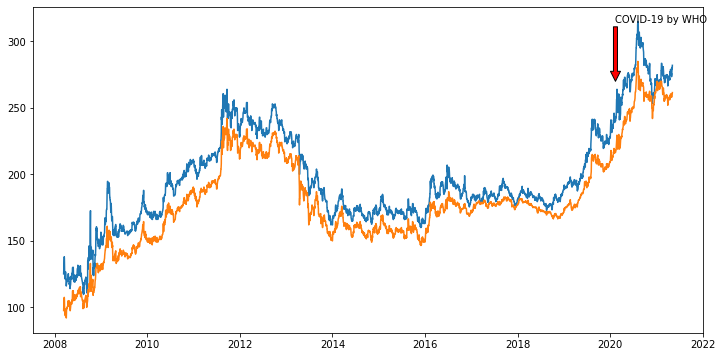

In [757]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(date_gold, gold24k['buy']/1000)
ax.plot(date_gold, gold24k['sell_24k']/1000)
ax.annotate('COVID-19 by WHO', xy = (datetime(2020, 2, 12),(gold24k2['buy'].asof(datetime(2020, 2, 12)))/1000 + 30),
           xytext=(datetime(2020, 2, 12),(gold24k2['buy'].asof(datetime(2020, 2, 12)))/1000 + 80),
                   arrowprops=dict(facecolor='red', headwidth=10, width=4,
                                headlength=10),
                horizontalalignment='left', verticalalignment='top')


In [899]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(date_gold, gold24k['buy'], c = 'k', ls = '-.', label = 'buy')
ax.plot(date_gold, gold24k['sell_24k'], c='gray', ls = '--', label = 'sell')

for date, event in crisis_data:
    ax.annotate(event, xy=(date, gold24k2['buy'].asof(date) + 30000),
                xytext=(date, gold24k2['buy'].asof(date) + 80000),
                arrowprops=dict(facecolor='red', headwidth=10, width=4,
                                headlength=10, ls = '--'),
                horizontalalignment='left', verticalalignment='top', c='b', fontsize = 10)
#ax.set_xlim([datetime(2007, 1, 1), datetime(2011, 1, 1)])
ax.set_title('< daily gold price fluctuation >', fontsize = 20)
ax.set_xlabel('Time')
ax.set_ylabel('Won')
ax.legend(loc = 2, fontsize = 12)
plt.show()

StopIteration: 

<Figure size 864x432 with 1 Axes>

In [801]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(date_gold, gold24k['buy'])
ax.plot(date_gold, gold24k['sell_24k'])

for date, event in crisis_data:
    ax.annotate(event, xy=(date, gold24k2['buy'].asof(date) + 75),
                xytext=(date, gold24k2['buy'] + 225),
                arrowprops=dict(facecolor='red', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left', verticalalignment='top')
#ax.set_xlim([datetime(2007, 1, 1), datetime(2011, 1, 1)])
plt.show()

TypeError: cannot convert the series to <class 'float'>

<Figure size 864x432 with 1 Axes>

In [619]:
gold24k.loc(datetime(2008, 3, 13))

ValueError: No axis named 2008-03-13 00:00:00 for object type DataFrame

TypeError: '<' not supported between instances of 'datetime.datetime' and 'int'

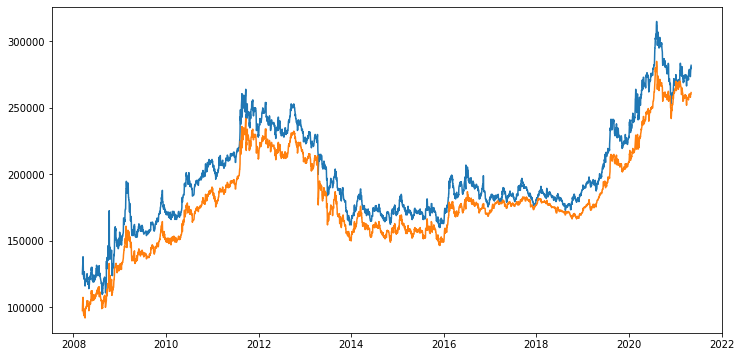

In [634]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(date_gold, gold24k['buy'])
ax.plot(date_gold, gold24k['sell_24k'])

for date, event in crisis_data:
    ax.annotate(event, xy=(date, gold24k[['date','buy']].asof(date) + 75),
                xytext=(date, gold24k[['date','buy']].asof(date) + 225),
                arrowprops=dict(facecolor='red', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left', verticalalignment='top')
#ax.set_xlim([datetime(2007, 1, 1), datetime(2011, 1, 1)])
plt.show()

In [636]:
gold24k[['date','buy']].asof(datetime(2017, 5, 9))

TypeError: '<' not supported between instances of 'datetime.datetime' and 'int'

In [598]:
gold24k.date.asof

<bound method NDFrame.asof of 0       2021.05.06
1       2021.05.05
2       2021.05.04
3       2021.05.03
4       2021.05.01
           ...    
3994    2008.03.17
3995    2008.03.15
3996    2008.03.14
3997    2008.03.13
3998    2008.03.12
Name: date, Length: 3999, dtype: object>

In [604]:
gold24k['date']

0       2021.05.06
1       2021.05.05
2       2021.05.04
3       2021.05.03
4       2021.05.01
           ...    
3994    2008.03.17
3995    2008.03.15
3996    2008.03.14
3997    2008.03.13
3998    2008.03.12
Name: date, Length: 3999, dtype: object

In [ ]:
datetime(2008, 3, 12)

NameError: name 'spx' is not defined

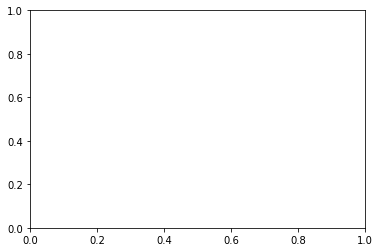

In [590]:
fig, ax = plt.subplots()

spx.plot(ax=ax, style='k--')

for date, event in crisis_data:
    ax.annotate(event, xy=(date, gold24k.asof(date) + 75),
                xytext=(date, gold24k.asof(date) + 225),
                arrowprops=dict(facecolor='red', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left', verticalalignment='top')

# Zoom in on 2007-2010
#ax.set_xlim(['1/1/2007', '1/1/2011'])
#ax.set_ylim([600, 1800])

#ax.set_title('Important dates in the 2008-2009 financial crisis')

In [ ]:
gold24k.as

In [570]:
gold24k['buy']

0       282,000
1       279,500
2       280,500
3       278,500
4       276,000
         ...   
3994    138,050
3995    133,650
3996    130,020
3997    128,370
3998    125,180
Name: buy, Length: 3999, dtype: object

In [547]:
raw_data

['2021.05.06282,000261,500188,300145,200',
 '2021.05.05279,500260,500187,600144,600',
 '2021.05.04280,500260,500187,600144,600',
 '2021.05.03278,500260,000187,200144,300',
 '2021.05.01276,000259,500186,900144,100',
 '2021.04.30273,500258,000185,800143,200',
 '2021.04.29276,000259,500186,900144,100',
 '2021.04.28275,000258,500186,200143,500',
 '2021.04.27275,500259,500186,900144,100',
 '2021.04.26276,500260,000187,200144,300',
 '2021.04.24277,000260,000187,200144,300',
 '2021.04.23278,500260,500187,600144,600',
 '2021.04.22279,000260,500187,600144,600',
 '2021.04.21276,500259,000186,500143,800',
 '2021.04.20275,000258,500186,200143,500',
 '2021.04.19277,500259,500186,900144,100',
 '2021.04.17277,000259,000186,500143,800',
 '2021.04.16275,000258,500186,200143,500',
 '2021.04.15271,000256,000184,400142,100',
 '2021.04.14272,500257,500185,400143,000',
 '2021.04.13271,500257,000185,100142,700',
 '2021.04.12273,000257,500185,400143,000',
 '2021.04.10273,000257,500185,400143,000',
 '2021.04.0

In [538]:
raw_dict['date']

KeyError: 'date'

In [530]:
raw_data[0][10:]

'282,000261,500188,300145,200'

In [535]:
re.findall('\d+,\d{3}', raw_data[0][10:])

['282,000', '261,500', '188,300', '145,200']

In [510]:
text.split('\n')

['2017.11.18183,500176,500127,10098,000',
 '2017.11.17182,500175,500126,40097,500',
 '2017.11.16182,500176,000126,80097,700',
 '2017.11.15185,000179,000128,90099,400',
 '2017.11.14185,000179,000128,90099,400',
 '2017.11.13185,500180,000129,600100,000',
 '2017.11.11185,500180,500130,000100,200',
 '2017.11.10186,000181,000130,400100,500',
 '2017.11.09184,500180,500130,000100,200',
 '2017.11.08184,000180,500130,000100,200',
 '2017.11.07184,500180,500130,000100,200',
 '2017.11.06183,500179,500129,30099,700',
 '2017.11.04184,000180,000129,600100,000',
 '2017.11.03184,000180,000129,600100,000',
 '2017.11.02184,000180,000129,600100,000',
 '2017.11.01184,000180,000129,600100,000',
 '2017.10.31185,500180,500130,000100,200',
 '2017.10.30185,500180,500130,000100,200',
 '2017.10.28185,500180,500130,000100,200',
 '2017.10.27185,500180,500130,000100,200',
 '2017.10.26186,500181,000130,400100,500',
 '2017.10.25186,500181,000130,400100,500',
 '2017.10.24187,500181,500130,700100,800',
 '2017.10.23187,5

In [461]:
np.floor(3999/15)

266.0

In [459]:
import numpy as np

In [467]:
temp = data_test.text

In [469]:
temp1 = temp.split('\n')

In [488]:
temp1[3]

'2008.04.09119,57099,10072,83856,486'

In [486]:
re.match('\d+.\d{2}.\d{2}', temp1[3])[0]

'2008.04.09'

In [489]:
temp1[3][10:]

'119,57099,10072,83856,486'

In [490]:
re.findall('\d+,\d{3}', temp1[3][10:])

['119,570', '99,100', '72,838', '56,486']